<a href="https://colab.research.google.com/github/Nicolas-BZRD/NLP-Classification-Toxic-Comments/blob/main/Classification_toxic_comments_DeepL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import GRU, Dense, Embedding
from tensorflow.keras import Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#Load data

In [3]:
data = pd.read_csv('/content/drive/MyDrive/Google_Colab/NLP_Classification_Toxic_Comments/train.csv')
data.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


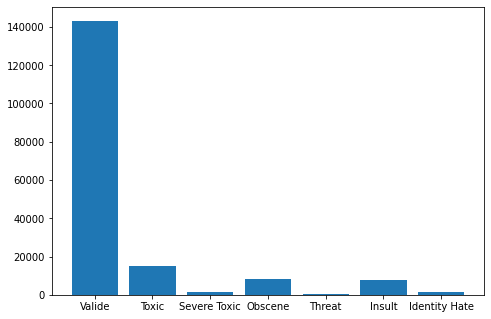

In [4]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
types = ['Valide', 'Toxic', 'Severe Toxic','Obscene', 'Threat', 'Insult', 'Identity Hate']
values = [
          len(data[(data['toxic'] == 0) & (data['severe_toxic'] == 0) & (data['obscene'] == 0) & (data['threat'] == 0) & (data['insult'] == 0) & (data['identity_hate'] == 0)]),
          data['toxic'].value_counts()[1],
          data['severe_toxic'].value_counts()[1],
          data['obscene'].value_counts()[1],
          data['threat'].value_counts()[1],
          data['insult'].value_counts()[1],
          data['identity_hate'].value_counts()[1],
          ]
ax.bar(types,values)
plt.show()

In [5]:
valide_indices = data.index[(data['toxic'] == 0) & (data['severe_toxic'] == 0) & (data['obscene'] == 0) & (data['threat'] == 0) & (data['insult'] == 0) & (data['identity_hate'] == 0)]
data.drop(valide_indices[:int(len(valide_indices) * 0.8)], inplace=True)

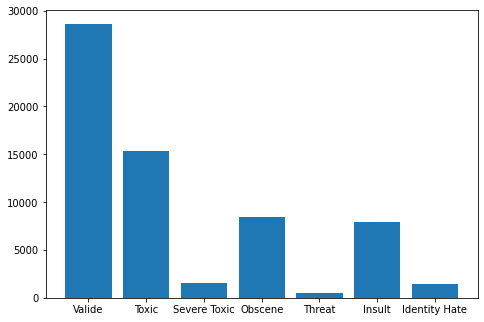

In [6]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
types = ['Valide', 'Toxic', 'Severe Toxic','Obscene', 'Threat', 'Insult', 'Identity Hate']
values = [
          len(data[(data['toxic'] == 0) & (data['severe_toxic'] == 0) & (data['obscene'] == 0) & (data['threat'] == 0) & (data['insult'] == 0) & (data['identity_hate'] == 0)]),
          data['toxic'].value_counts()[1],
          data['severe_toxic'].value_counts()[1],
          data['obscene'].value_counts()[1],
          data['threat'].value_counts()[1],
          data['insult'].value_counts()[1],
          data['identity_hate'].value_counts()[1],
          ]
ax.bar(types,values)
plt.show()

In [7]:
stop_word = list(stopwords.words('english'))

In [8]:
data['comment_text'] = data['comment_text'].apply(lambda x : x.replace('\ufeff', ''))
data['comment_text'] = data['comment_text'].apply(lambda x : x.replace('\xa0', ''))
data['comment_text'] = data['comment_text'].apply(lambda x : x.replace('&#39;', ' '))
data['comment_text'] = data['comment_text'].apply(lambda x : x.lower())
data['comment_text'] = data['comment_text'].apply(lambda x : ''.join([i for i in x if not i.isdigit()]))
data['comment_text'] = data['comment_text'].apply(lambda x : ''.join([w+' ' for w in x.split() if not w in stop_word]))


In [9]:
data.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,cocksucker piss around work,1,1,1,0,1,0
12,0005c987bdfc9d4b,hey... it.. @ | talk . it... exclusive group w...,1,0,0,0,0,0
16,0007e25b2121310b,"bye! look, come think comming back! tosser.",1,0,0,0,0,0
42,001810bf8c45bf5f,gay antisemmitian? archangel white tiger meow!...,1,0,1,0,1,1
43,00190820581d90ce,"fuck filthy mother ass, dry!",1,0,1,0,1,0


#Pre-processing text

In [10]:
def avg(lst):
  tmp = 0
  for i in lst:
    tmp = tmp+len(i)
  return int(tmp/len(lst))

In [11]:
x = data['comment_text'].to_numpy()

In [12]:
tok = Tokenizer()
tok.fit_on_texts(x)

vocab_size = len(tok.word_index)
x_tok = tok.texts_to_sequences(x)
max_length = len(max(x_tok, key=len))
avr_length = avg(x_tok)

print("Number voc: {}, max length: {}, average size: {}".format(vocab_size, max_length, avr_length))

Number voc: 85502, max length: 1349, average size: 35


In [13]:
x_tok = tok.texts_to_sequences(x)

In [14]:
x_tok = pad_sequences(x_tok,padding="post", maxlen=1349)

In [15]:
print(x[0])
print(tok.texts_to_sequences(["cocksucker"]))
print(x_tok[0])

cocksucker piss around work 
[[517]]
[ 517 1414  212 ...    0    0    0]


#Model

##Toxic

In [16]:
y = data['toxic'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(x_tok, y, test_size=0.2, random_state=1)

In [17]:
model_tox = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 100, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(int(avr_length))),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_tox.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_tox.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1349, 100)         8550200   
                                                                 
 bidirectional (Bidirectiona  (None, 70)               28770     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 70)                0         
                                                                 
 dense (Dense)               (None, 6)                 426       
                                                                 
 dropout_1 (Dropout)         (None, 6)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                        

In [18]:
weight = np.ones(shape=(len(y_train),))
weight[y_train == 1] = int(y_train.tolist().count(0)/y_train.tolist().count(1))

In [ ]:
history = model_tox.fit(X_train, y_train, validation_data=(X_test, y_test), sample_weight=weight, batch_size=256, epochs=5)

Epoch 1/5
 18/141 [==>...........................] - ETA: 8:40 - loss: 0.6626 - accuracy: 0.6554

In [ ]:
model_tox.predict(X_test[0:5])

In [ ]:
y_test[0:5]

##Severe toxic

In [ ]:
y = data['severe_toxic'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(x_tok, y, test_size=0.2, random_state=1)

In [ ]:
model_svr_tox = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 100, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(int(avr_length))),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_svr_tox.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_svr_tox.summary()

In [ ]:
weight = np.ones(shape=(len(y_train),))
weight[y_train == 1] = int(y_train.tolist().count(0)/y_train.tolist().count(1))

In [ ]:
history = model_svr_tox.fit(X_train, y_train, validation_data=(X_test, y_test), sample_weight=weight, batch_size=256, epochs=5)

In [ ]:
model_svr_tox.predict(X_test[0:5])

In [ ]:
y_test[0:5]

##Obscene

In [ ]:
y = data['obscene'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(x_tok, y, test_size=0.2, random_state=1)

In [ ]:
model_obscene = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 100, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(int(avr_length))),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_obscene.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_obscene.summary()

In [ ]:
weight = np.ones(shape=(len(y_train),))
weight[y_train == 1] = int(y_train.tolist().count(0)/y_train.tolist().count(1))

In [ ]:
history = model_obscene.fit(X_train, y_train, validation_data=(X_test, y_test), sample_weight=weight, batch_size=256, epochs=5)

In [ ]:
model_obscene.predict(X_test[0:5])

In [ ]:
y_test[0:5]

##Threat

In [ ]:
y = data['threat'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(x_tok, y, test_size=0.2, random_state=1)

In [ ]:
model_threat = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 100, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(int(avr_length))),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_threat.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_threat.summary()

In [ ]:
weight = np.ones(shape=(len(y_train),))
weight[y_train == 1] = int(y_train.tolist().count(0)/y_train.tolist().count(1))

In [ ]:
history = model_threat.fit(X_train, y_train, validation_data=(X_test, y_test), sample_weight=weight, batch_size=256, epochs=5)

In [ ]:
model_threat.predict(X_test[0:5])

In [ ]:
y_test[0:5]

##Insult

In [ ]:
y = data['insult'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(x_tok, y, test_size=0.2, random_state=1)

In [ ]:
model_insult = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 100, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(int(avr_length))),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_insult.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_insult.summary()

In [ ]:
weight = np.ones(shape=(len(y_train),))
weight[y_train == 1] = int(y_train.tolist().count(0)/y_train.tolist().count(1))

In [ ]:
history = model_insult.fit(X_train, y_train, validation_data=(X_test, y_test), sample_weight=weight, batch_size=256, epochs=5)

In [ ]:
model_insult.predict(X_test[0:5])

In [ ]:
y_test[0:5]

##Identity hate

In [ ]:
y = data['identity_hate'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(x_tok, y, test_size=0.2, random_state=1)

In [ ]:
model_identity_hate = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 100, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(int(avr_length))),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_identity_hate.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_identity_hate.summary()

In [ ]:
weight = np.ones(shape=(len(y_train),))
weight[y_train == 1] = int(y_train.tolist().count(0)/y_train.tolist().count(1))

In [ ]:
history = model_identity_hate.fit(X_train, y_train, validation_data=(X_test, y_test), sample_weight=weight, batch_size=256, epochs=5)

In [ ]:
model_identity_hate.predict(X_test[0:5])

In [ ]:
y_test[0:5]

#Result

In [ ]:
y = data.iloc[:, 2:].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(x_tok, y, test_size=0.2, random_state=1)

In [ ]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
def compareColumnPredictTarget(column, X, Y):
  error = 0
  success = 0
  true_pos = 0
  true_neg = 0
  false_pos = 0
  false_neg = 0
  for i in range(len(X)):
    if X[i][column] != Y[i][column]:
      error = error + 1
      if(X[i][column] == 1 and Y[i][column] == 0):
        false_pos = false_pos + 1
      else:
        false_neg = false_neg + 1
    else:
      success = success + 1
      if(X[i][column] == 1):
        true_pos = true_pos+1
      else:
        true_neg = true_neg+1
  return error, success, true_pos, true_neg, false_pos, false_neg

In [ ]:
tox = model_tox.predict(X_test)
srv_tox = model_svr_tox.predict(X_test)
obsc = model_obscene.predict(X_test)
threat = model_threat.predict(X_test)
insult = model_insult.predict(X_test)
hate = model_identity_hate.predict(X_test)

In [ ]:
Y_predict = []
for index in range(0,len(X_test)):
  tmp = []
  tmp.append(1 if tox[index] > 0.6 else 0)
  tmp.append(1 if srv_tox[index] > 0.95 else 0)
  tmp.append(1 if obsc[index] > 0.7 else 0)
  tmp.append(1 if threat[index] > 0.92 else 0)
  tmp.append(1 if insult[index] > 0.8 else 0)
  tmp.append(1 if hate[index] > 0.9 else 0)
  Y_predict.append(tmp)

for i in range(len(labels)):
  error, success, true_pos, true_neg, false_pos, false_neg = compareColumnPredictTarget(i,Y_predict,y_test)
  print("For label : {0} we have {1} success ({2} true positive and {3} true negative) and {4} errors ({5} false positive and {6} false negative) / Precision: {7}, Recall {8}.".format(labels[i], success, true_pos, true_neg, error, false_pos, false_neg, true_pos/(true_pos+false_pos), true_pos/(true_pos+false_neg)))